# Data Science experiment from https://www.kaggle.com/competitions/spaceship-titanic/overview

# I do not want to rush for the best results on kaggle possible. In real life one could not predict which model is the best and i just want to study and excercise dataScience

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

data_train = train.copy()
data_test = test.copy()

## Copied from https://www.kaggle.com/competitions/spaceship-titanic/data

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence. 

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.  

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  

Destination - The planet the passenger will be debarking to.  

Age - The age of the passenger.  

VIP - Whether the passenger has paid for special VIP service during the voyage.  

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  

Name - The first and last names of the passenger.  

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [3]:
data_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
numerical_features = data_train.copy().select_dtypes(include=[np.number])
categorical_features = data_train.copy().select_dtypes(include=[object, bool])

print(numerical_features.columns)
print(categorical_features.columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported'],
      dtype='object')


In [5]:
cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical ))

In [6]:
num_summary_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(num_summary_stats, 'numerical_features', 'Summary statistics for numerical features')

display(HTML(html_numerical ))

In [7]:
null_values = data_train.isnull().sum()
print("NUMBER OF OBS: ", len(data_train))
print(null_values)

NUMBER OF OBS:  8693
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [8]:
null_values = data_test.isnull().sum()
print("NUMBER OF OBS: ", len(data_test))
print(null_values)

NUMBER OF OBS:  4277
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Is the lack of data present in the same rows or they are present 'randomly'?

In [9]:
copy = data_train.copy()
copy['nullCount'] = copy.isnull().sum(axis=1)
copy.sort_values(by=['nullCount'], ascending=False, inplace=True)

In [10]:
copy.head()

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
3882     4167_01      Earth     False       NaN  PSO J318.5-22   NaN    NaN   
7211     7703_02        NaN      True  G/1251/S    TRAPPIST-1e  13.0  False   
2639     2822_02      Earth       NaN   G/450/S    TRAPPIST-1e   5.0    NaN   
4164     4446_05     Europa       NaN   B/175/S    TRAPPIST-1e  33.0  False   
7682     8202_03        NaN      True   C/306/S    TRAPPIST-1e   NaN  False   

      RoomService  FoodCourt  ShoppingMall  Spa  VRDeck              Name  \
3882          0.0      440.0           0.0  0.0   334.0  Ninaha Deckerson   
7211          0.0        0.0           NaN  0.0     0.0               NaN   
2639          0.0        0.0           0.0  0.0     NaN   Salley Harverez   
4164          0.0     4017.0           NaN  NaN  2260.0    Phah Chocaters   
7682          0.0        0.0           0.0  0.0     NaN  Charga Unkcatted   

      Transported  nullCount  
3882        False          3  
7211         True          3  
2639        False          3  
4164         True          3  
7682         True          3

### At most 3 columns are null simultanously so there are no empty rows 

# Below i handle with categorical Cabin

### At first i will dive into this variable because it has many unique values and drawing count plot would be absurd.   
### As we can see from data description, from Cabin we can take information about deck and side

In [11]:
import math
data_train['CabinDeck'] = data_train['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[0] if type(x) is str else 'Unknown')
data_train['CabinSide'] = data_train['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[2] if type(x) is str else 'Unknown')
data_train['CabinNum'] = data_train['Cabin'].apply(lambda x: int((x or 'Unknown/Unknown/Unknown').split('/')[1]) if type(x) is str else -1)

# after the split Cabin is no more useful

data_train.drop(columns='Cabin', inplace=True)

# refresh numerical and categorical features
numerical_features = data_train.copy().select_dtypes(include=[np.number])
categorical_features = data_train.copy().select_dtypes(include=[object, bool]) 

### CabinNum may be useless but i will check whether the 'bigness' of the number influence on dependent variable

In [12]:
copy = data_train.copy()[['Transported', 'CabinNum']]
copy['q_2'] = pd.qcut(copy['CabinNum'], q=[0, 0.5, 1],
                         labels=["lowest", "top"])

copy['q_4'] = pd.qcut(copy['CabinNum'], q=[0, 0.25, 0.5, 0.75, 1],
                         labels=["q1", "q2", "q3", "q4"])


In [13]:
print(pd.pivot_table(copy, columns=['q_2'], index=['Transported'], aggfunc='count'))
print(pd.pivot_table(copy, columns=['q_4'], index=['Transported'], aggfunc='count'))



            CabinNum          q_4      
q_2           lowest   top lowest   top
Transported                            
False           2081  2234   2081  2234
True            2269  2109   2269  2109
            CabinNum                     q_2                  
q_4               q1    q2    q3    q4    q1    q2    q3    q4
Transported                                                   
False           1007  1074  1081  1153  1007  1074  1081  1153
True            1167  1102  1089  1020  1167  1102  1089  1020


### The numbers seems to be equally distributed so the CabinNum variable is useless

In [14]:
data_train.drop(columns=['CabinNum'], inplace=True)

# Below i handle with categorical Name

### Name is almost unique so it will be useless for making predictions

In [15]:
data_train.drop(columns=['Name'], inplace=True)

# refresh numerical and categorical features
numerical_features = data_train.copy().select_dtypes(include=[np.number])
categorical_features = data_train.copy().select_dtypes(include=[object, bool]) 

### Below i plot counts of other categorical variables

In [16]:
categorical_features.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
       'Transported', 'CabinDeck', 'CabinSide'],
      dtype='object')

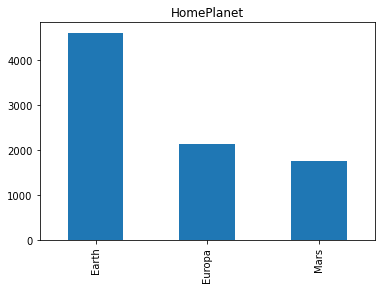

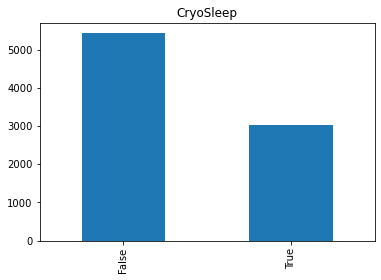

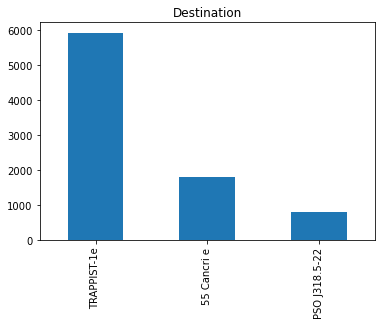

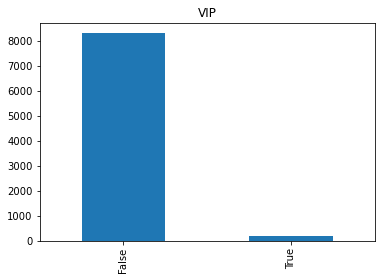

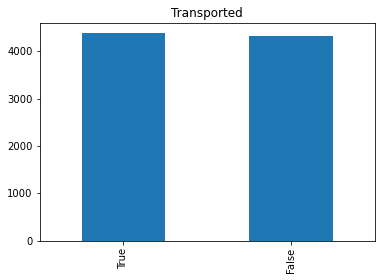

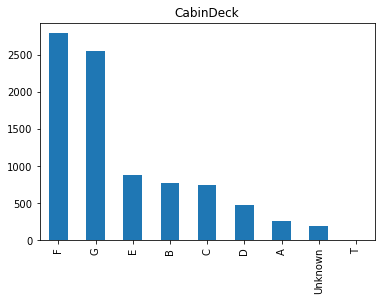

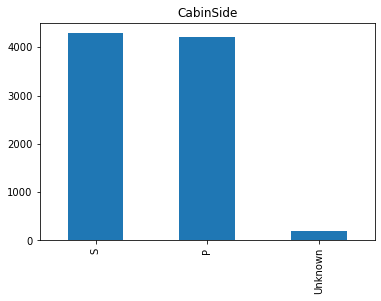

In [17]:
for col in categorical_features.drop(columns=['PassengerId']).columns:
    data_train[col].value_counts().plot(kind='bar', title=col)
    plt.show()

### Earlier the count table for null values was displayed. For such values we could assign the most frequent value or assign 'Unknown' value (dropping row with such missing values would not be good because test data also has missing values and these have to be handled either way). I decide to:
##### Home planet: assign 'Unknown'  
##### CryoSleep: assign 'Unknown'  
##### destination: assign 'Unknown'  
##### Vip: assign False to null values (as very few observations are Vips)

In [18]:
data_train[['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck']] = data_train[['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck']].fillna('Unknown')
data_train['VIP'].fillna(False, inplace=True)
           
# refresh numerical and categorical features
numerical_features = data_train.copy().select_dtypes(include=[np.number])
categorical_features = data_train.copy().select_dtypes(include=[object, bool]) 

# Below are histogram of numerical variable

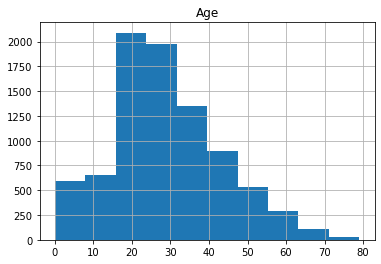

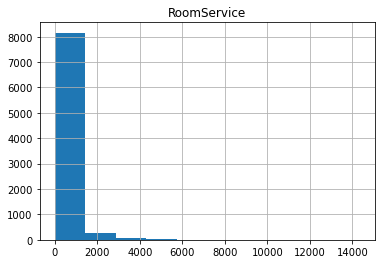

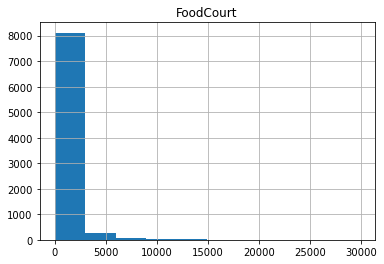

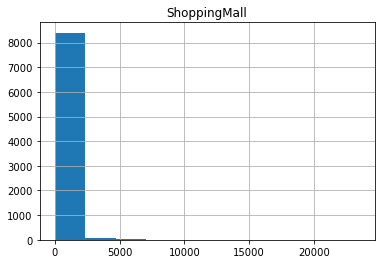

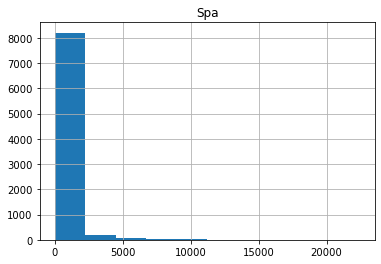

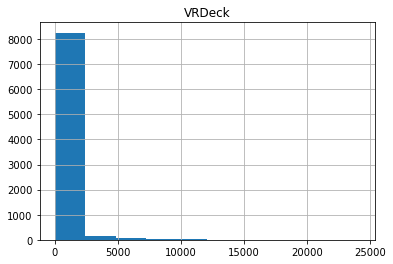

In [19]:
for col in numerical_features.columns:
    data_train[col].hist()
    plt.title(col)
    plt.show()

In [20]:
for col in numerical_features.columns:
    print(col, len(data_train[data_train[col] == 0]))

Age 178
RoomService 5577
FoodCourt 5456
ShoppingMall 5587
Spa 5324
VRDeck 5495


### There are many people who does not use at least one of the paid option. Instead of using this numerical columns maybe it would be more useful to transform into binomial  variable: 'does_he_paid_for_[option]' 

### If we also look at quantiles of numerical features, the scale is huge and most of the values are pretty small

### For age i will fill missing values with mean (median is almost the same so there is a minor difference). I think the standarization can deal with the problem ( I do not think i want to detect and remove outliers)

In [21]:
mean = data_train['Age'].mean()
data_train['Age'].fillna(mean, inplace=True)
data_train['Age'].replace(0, mean, inplace=True)

# refresh numerical and categorical features
numerical_features = data_train.copy().select_dtypes(include=[np.number])
categorical_features = data_train.copy().select_dtypes(include=[object, bool]) 

### Fo other numerical i will replace missing values with median (which is i think every time equal 0)

In [22]:
data_train[numerical_features.columns] = data_train[numerical_features.columns].fillna(data_train[numerical_features.columns].median())

### Correlation between numerical variables

In [23]:
c = numerical_features.corr()
print(c)

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.056972   0.122809      0.022280  0.115869   
RoomService   0.056972     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.122809    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.022280     0.054480  -0.014228      1.000000  0.013879   
Spa           0.115869     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.093471    -0.019581   0.227995     -0.007322  0.153821   

                VRDeck  
Age           0.093471  
RoomService  -0.019581  
FoodCourt     0.227995  
ShoppingMall -0.007322  
Spa           0.153821  
VRDeck        1.000000  


<AxesSubplot:>

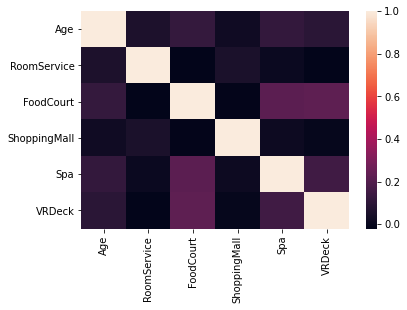

In [24]:
sns.heatmap(c)

### there is no correlation between any of the numerical variables (so there will be no problem inputing all numerical variables to a potencial model).

### Before building a model, can we say something about "Transported" by looking at dependencies between categorical variables and "Transported" column? Below are the pivot tables.

In [25]:
for col in categorical_features.drop(columns=['PassengerId', 'Transported']).columns:
    print(pd.pivot_table(data_train, values='PassengerId', columns=col, index='Transported', aggfunc='count'))

HomePlanet   Earth  Europa  Mars  Unknown
Transported                              
False         2651     727   839       98
True          1951    1404   920      103
CryoSleep    False  True  Unknown
Transported                      
False         3650   554      111
True          1789  2483      106
Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e  Unknown
Transported                                                  
False                702            395         3128       90
True                1098            401         2787       92
VIP          False  True 
Transported              
False         4192    123
True          4302     76
CabinDeck      A    B    C    D    E     F     G  T  Unknown
Transported                                                 
False        129  207  239  271  563  1565  1238  4       99
True         127  572  508  207  313  1229  1321  1      100
CabinSide       P     S  Unknown
Transported                     
False        2308  1908       99
T

# Building and testing models.

### Before that lets standarize numerical and do one hot encoding

In [26]:
from sklearn.preprocessing import MinMaxScaler

data_train_s = data_train.copy()
scaler = MinMaxScaler()

data_train_s[numerical_features.columns] = scaler.fit_transform(data_train_s[numerical_features.columns])
data_train_s.drop(columns=['PassengerId'], inplace=True)

data_train_s_dum = pd.get_dummies(data_train_s)

X = data_train_s_dum.drop(columns=['Transported'])
y = data_train_s_dum['Transported']

## Logistic regression

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200)
lr_scores = cross_val_score(lr, X, y, cv=5, scoring='accuracy')

In [28]:
lr_scores

array([0.75560667, 0.76825762, 0.7573318 , 0.76927503, 0.77445339])

## Random tree classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

rtc = DecisionTreeClassifier(random_state=17)
rtc_scores = cross_val_score(rtc, X, y, cv=5, scoring='accuracy')

In [30]:
rtc_scores

array([0.7280046 , 0.7280046 , 0.75158137, 0.72957422, 0.72612198])

## Random forest classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=17)
rfc_scores = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')

In [32]:
rfc_scores

array([0.77573318, 0.78148361, 0.78895917, 0.79344074, 0.79286536])

## Gradient Boosting Classifier

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.2, random_state=17)
gbc_scores = cross_val_score(gbc, X, y, cv=5, scoring='accuracy')

In [34]:
gbc_scores

array([0.786659  , 0.7906843 , 0.79988499, 0.82048331, 0.80034522])

## Support Vector Machines

In [35]:
from sklearn import svm

svc = svm.SVC()
svc_scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')

In [36]:
svc_scores

array([0.73145486, 0.75215641, 0.74008051, 0.7456847 , 0.74741082])

## Naive bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_scores = cross_val_score(gnb, X, y, cv=5, scoring='accuracy')

In [38]:
gnb_scores

array([0.72570443, 0.61644623, 0.76595745, 0.77963176, 0.73130035])

### To sum up

In [39]:
print("Logistic regression score: ", lr_scores.mean())
print("Random tree score: ", rtc_scores.mean())
print("Random forest score: ", rfc_scores.mean())
print("Gradient boosting score: ", gbc_scores.mean())
print("Support vector score: ", svc_scores.mean())
print("Naive Bayes score: ", gnb_scores.mean())

Logistic regression score:  0.7649849026363974
Random tree score:  0.7326573543648686
Random forest score:  0.7864964124323134
Gradient boosting score:  0.7996113661343933
Support vector score:  0.743357457793224
Naive Bayes score:  0.7238080427953845


### Train on full data and get results to be uploaded on Kaggle

### Firstly, test_data has to be transformed to fit train_data

In [40]:
data_test.isnull().sum(), data_test.shape

(PassengerId       0
 HomePlanet       87
 CryoSleep        93
 Cabin           100
 Destination      92
 Age              91
 VIP              93
 RoomService      82
 FoodCourt       106
 ShoppingMall     98
 Spa             101
 VRDeck           80
 Name             94
 dtype: int64,
 (4277, 13))

In [41]:
def prepareCategoricalFeatures(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.drop(columns=['Name'], inplace=True)
    d['CabinDeck'] = d['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[0] if type(x) is str else 'Unknown')
    d['CabinSide'] = d['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[2] if type(x) is str else 'Unknown')

    # after the split Cabin is no more useful
    d.drop(columns='Cabin', inplace=True)

    d[['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck']] = d[['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck']].fillna('Unknown')
    d['VIP'].fillna(False, inplace=True)
    
    return d

In [42]:
data_test_s = data_test.copy()
data_test_s = prepareCategoricalFeatures(data_test_s)
          
mean = data_test_s['Age'].mean()
data_test_s['Age'].fillna(mean, inplace=True)
data_test_s['Age'].replace(0, mean, inplace=True)
      
num_cols = data_test_s.select_dtypes(include=[np.number]).columns

data_test_s[num_cols] = data_test_s[num_cols].fillna(data_test_s[num_cols].median())

# here we have to use existing scaler which is trained on data_train
data_test_s[num_cols] = scaler.transform(data_test_s[num_cols])

ids = data_test_s['PassengerId']
data_test_s.drop(columns=['PassengerId'], inplace=True)
data_test_s_dum = pd.get_dummies(data_test_s)

In [43]:
classifiers = [
    {'name': 'log_reg', 'classifier': LogisticRegression(max_iter=200)},
    {'name': 'decision_tree', 'classifier': DecisionTreeClassifier(random_state=17)},
    {'name': 'random_forest', 'classifier': RandomForestClassifier(random_state=17)},
    {'name': 'gradient_boost', 'classifier': GradientBoostingClassifier(learning_rate=0.2, random_state=17)},
    {'name': 'support_vector', 'classifier': svm.SVC()},
    {'name': 'naive_bayes', 'classifier': GaussianNB()},
]

In [44]:
run = False

In [45]:
if run == True:
    for c in classifiers:
        c['classifier'].fit(X, y)
        preds = c['classifier'].predict(data_test_s_dum)
        df = pd.DataFrame({'PassengerId': ids, 'Transported': preds})
        df.to_csv(f"preds/{c['name']}_submission.csv", index=False)

## Accuracy of models on Kaggle with such submissions:
- decision tree: 0.74  
- support vector classifier: 0.75
- naive Bayes classifier: 0.75 
- logistic regression: 0.77
- random forest: 0.79
- gradient boosting: 0.80

## Because numerical features have huge range and median is EVERYWHERE 0 (apart from age) i will try to make discrete values from this

In [46]:
data_train_2 = train.copy()
data_test_2 = test.copy()

# refresh numerical and categorical features
numerical_features = data_train_2.copy().select_dtypes(include=[np.number])
categorical_features = data_train_2.copy().select_dtypes(include=[object, bool]) 

In [47]:
numerical_features.drop(columns=['Age']).quantile([.5, .7, .8, .9, .95, .99], interpolation="nearest")

RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
0.50          0.0        0.0           0.0     0.0     0.0
0.70          8.0       13.0           5.0    15.0     9.0
0.80        176.0      258.0          97.0   179.0   156.0
0.90        753.0     1026.0         620.0   732.0   733.0
0.95       1272.0     2762.0         928.0  1608.0  1539.0
0.99       3097.0     8037.0        2332.0  5391.0  5648.0

In [48]:
import math

for col in numerical_features.drop(columns=['Age']).columns:
    data_train_2[f"Used{col}"] = data_train_2[col].apply(lambda x: 0 if math.isnan(x) or x == 0 else 1)
    data_test_2[f"Used{col}"] = data_test_2[col].apply(lambda x: 0 if math.isnan(x) or x == 0 else 1)

data_train_2.drop(columns=numerical_features.drop(columns=['Age']).columns, inplace=True)
data_test_2.drop(columns=numerical_features.drop(columns=['Age']).columns, inplace=True)

mean = data_train_2['Age'].mean()
data_train_2['Age'].fillna(mean, inplace=True)
data_train_2['Age'].replace(0, mean, inplace=True)


In [49]:
data_train_2 = prepareCategoricalFeatures(data_train_2)
data_test_2 = prepareCategoricalFeatures(data_test_2)

X_2 = data_train_2.drop(columns=['Transported'])
y_2 = data_train_2['Transported']

X_2.drop(columns=['PassengerId'], inplace=True)
X_2 = pd.get_dummies(X_2)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

classifiers2 = [
    {'name': 'log_reg', 'classifier': LogisticRegression(max_iter=400)},
    {'name': 'decision_tree', 'classifier': DecisionTreeClassifier(random_state=17)},
    {'name': 'random_forest', 'classifier': RandomForestClassifier(random_state=17)},
    {'name': 'gradient_boost', 'classifier': GradientBoostingClassifier(learning_rate=0.2, random_state=17)},
    {'name': 'support_vector', 'classifier': svm.SVC()},
    {'name': 'naive_bayes', 'classifier': GaussianNB()},
]

In [51]:
from sklearn.model_selection import cross_val_score

for c in classifiers2:
    scores = cross_val_score(c['classifier'], X_2, y_2, cv=5, scoring='accuracy')
    print(f"{c['name']}: {scores}, where mean = {scores.mean()}")

log_reg: [0.72225417 0.73950546 0.74698102 0.74395857 0.73762946], where mean = 0.7380657375540218
decision_tree: [0.67452559 0.68142611 0.67165037 0.66340621 0.68009206], where mean = 0.6742200688066565
random_forest: [0.6906268  0.69925244 0.69005175 0.69965478 0.69620253], where mean = 0.6951576604148648
gradient_boost: [0.73893042 0.74468085 0.74698102 0.7589183  0.75086306], where mean = 0.7480747304609412
support_vector: [0.72110408 0.73260495 0.72052904 0.74741082 0.74626007], where mean = 0.7335817907862077
naive_bayes: [0.70960322 0.67797585 0.71190339 0.72669735 0.73302647], where mean = 0.7118412563335805


### The results above are a little bit worse than the results with normalised numerical features 